In [1]:
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt

Data source: https://fred.stlouisfed.org/series/DTB3

Data daterange: 1/11/2002 to 1/11/2022 (daily frequency of 20 years)

In [2]:
data = pd.read_csv("ratedata2.csv")
data.head()

,DATE,DTB3
0,1/11/2002,1.41
1,4/11/2002,1.41
2,5/11/2002,1.40
3,6/11/2002,1.21
4,7/11/2002,1.20


In [3]:
rate = data["DTB3"].values

#transfrom rate that <= 0 to 0.0001 te prevent neg value and zero division
rate = [0.0001 if item <= 0 else item for item in rate]      

ols_y = [(y- x)/np.sqrt(x) for x, y in zip(rate, rate[1:])]
ols_x1 = [1/np.sqrt(x) for x, y in zip(rate, rate[1:])]
ols_x2 = [np.sqrt(x) for x, y in zip(rate, rate[1:])]

df = data.drop(index=0, axis=0)
df["ols_y"] = ols_y
df["ols_x1"] = ols_x1
df["ols_x2"] = ols_x2
df.head()

,DATE,DTB3,ols_y,ols_x1,ols_x2
1,4/11/2002,1.41,0.000000,0.842152,1.187434
2,5/11/2002,1.40,-0.008422,0.842152,1.187434
3,6/11/2002,1.21,-0.160579,0.845154,1.183216
4,7/11/2002,1.20,-0.009091,0.909091,1.100000
5,8/11/2002,1.20,0.000000,0.912871,1.095445


In [4]:
x = df[['ols_x1','ols_x2']]
y = df['ols_y']

import statsmodels.api as sm
model = sm.OLS(y, x).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  ols_y   R-squared (uncentered):                   0.328
Model:                            OLS   Adj. R-squared (uncentered):              0.328
Method:                 Least Squares   F-statistic:                              1221.
Date:                Fri, 04 Nov 2022   Prob (F-statistic):                        0.00
Time:                        16:35:03   Log-Likelihood:                          5175.3
No. Observations:                5003   AIC:                                 -1.035e+04
Df Residuals:                    5001   BIC:                                 -1.033e+04
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
ols_x1         0.0083      0.000     49.422      0.000       0.008       0.009
ols_x2        -0.0065      0.001     -5.815      0.000      -0.009      -0.004
==============================================================================
Omnibus:                     7410.869   Durbin-Watson:                   1.803
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         10670007.292
Skew:                           8.433   Prob(JB):                         0.00
Kurtosis:                     228.612   Cond. No.                         6.76
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [5]:
ab = model.params[0]
minus_a = model.params[1]
a = -minus_a
b = ab/a
sigma = np.sqrt(model.scale)
print(a,b,sigma)

0.006542184098982086 1.267996322549537 0.08602000599670477


In [6]:
r0 = 4.06    #rate of 1/11/2022
I = 10000    #no of simulation
M = 252      #no of period 

In [7]:
import numpy.random as npr

def CIR_exact(kappa,theta,sigma,M,I,r0):
    dt = 1/M
    x = np.zeros((M+1,I))
    x[0] = r0
    for t in range(1, M+1):
        df = 4*theta*kappa / sigma**2
        c = (sigma ** 2 * (1- np.exp(-kappa * dt))) / (4 * kappa)
        nc = np.exp(-kappa*dt)/c*x[t-1]
        x[t] = c*npr.noncentral_chisquare(df,nc,size=I)
    return x

r = CIR_exact(a,b,sigma,M,I,r0)

In [8]:
r.shape

(253, 10000)

Text(0, 0.5, 'rate')

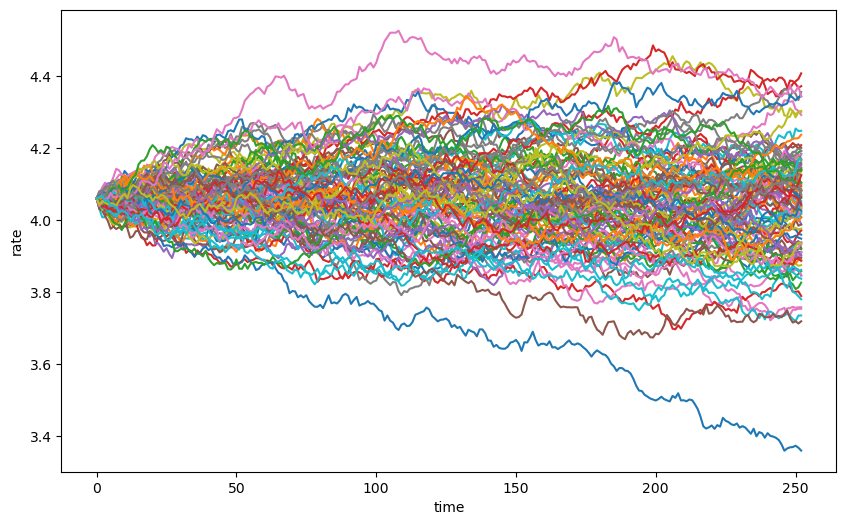

In [9]:
#Visualize first 100 paths
plt.figure(figsize=(10,6))
plt.plot(r[:,:100],lw=1.5)
plt.xlabel("time")
plt.ylabel("rate")

Text(0, 0.5, 'rate')

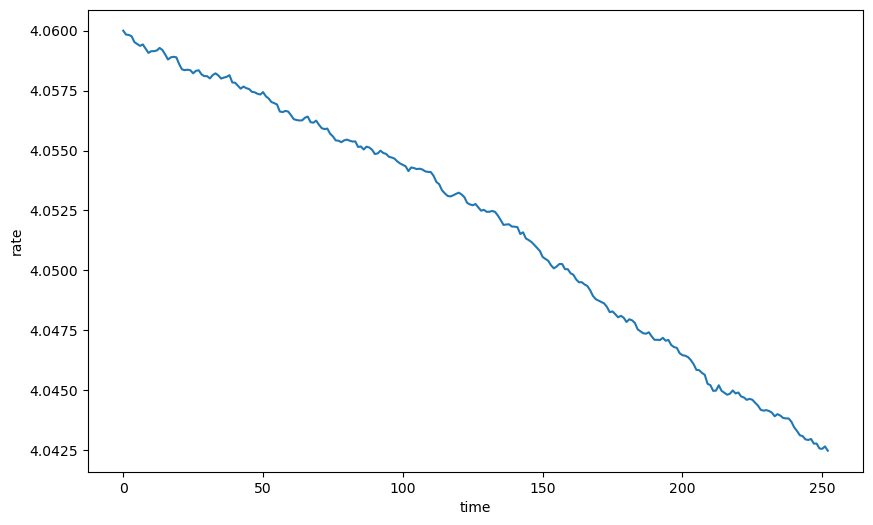

In [10]:
#take mean value on each period
mean_r = np.mean(r, axis=1)
plt.figure(figsize=(10,6))
plt.plot(mean_r,lw=1.5)
plt.xlabel("time")
plt.ylabel("rate")

In [12]:
#to_csv
"""d = {'rate': mean_r}
rate_df = pd.DataFrame(data=d)
rate_df.to_csv("estimated_rate.csv",index=False)"""

'd = {\'rate\': mean_r}\nrate_df = pd.DataFrame(data=d)\nrate_df.to_csv("estimated_rate.csv",index=False)'